In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import math
from statsmodels.stats.contingency_tables import mcnemar
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from matplotlib.colors import PowerNorm

import tkinter as tk
import os
import random
from transformers import pipeline
from sklearn.metrics import f1_score

from tqdm import tqdm



In [75]:

datasets = ['llama33', 'llama31', 'gpt4o', 'gpt4o_mini', 'qwen3_32B', 'enisear']

In [96]:
synth_datasets = {}
for dataset in datasets:

    synth_datasets[dataset] = pd.read_csv(f'full_emotions/{dataset}.csv', index_col=0)#.drop(columns=['pred_1', 'pred_2', 'pred_3', 'Unnamed: 0'])
    synth_datasets[dataset].drop(columns=['qwen3_30BA3B_label'], inplace=True)
    synth_datasets[dataset].rename(columns = {'qwen32B_label': 'qwen3_32B_label', 'gpt_4o_mini_label': 'gpt4o_mini_label', 'gpt_4o_label': 'gpt4o_label'}, inplace = True)



In [97]:
synth_datasets['llama31']

,Prior_Emotion,Sentence,Word_Count,gpt4o_label,gpt4o_mini_label,llama33_label,llama31_label,qwen3_32B_label
0,Fear,"when i was tasked with debugging a massive, co...",NaN,Fear,Fear,Fear,Fear,Fear
1,Shame,when i realized i had accidentally committed a...,NaN,Shame,Shame,Shame,Shame,Shame
2,Guilt,"when i was assigned a python project at work, ...",NaN,Guilt,Guilt,Guilt,Guilt,Guilt
3,Disgust,"when my colleague, who was supposed to be a se...",NaN,Disgust,Anger,Disgust,Disgust,Disgust
4,Sadness,"when i was told that our team's project, which...",NaN,Sadness,Sadness,Sadness,Sadness,Sadness
...,...,...,...,...,...,...,...,...
996,Guilt,when i accidentally overwrote a critical confi...,NaN,Guilt,Guilt,Guilt,Guilt,Guilt
997,Disgust,when my colleague intentionally deleted the en...,NaN,Anger,Anger,Anger,Anger,Anger
998,Sadness,when i received news that the company i had be...,NaN,Sadness,Sadness,Sadness,Sadness,Sadness
999,Anger,when our project manager unexpectedly assigned...,NaN,Anger,Anger,Anger,Fear,Fear


In [98]:
emotions = list(synth_datasets['enisear']['Prior_Emotion'].unique())
emotions


['Fear', 'Shame', 'Guilt', 'Disgust', 'Sadness', 'Anger', 'Joy']

## Quality Check

In [99]:
# tkinter app to manually check quality of a random sample per dataset

class label_text:
    def __init__(self, input_file_name, output_file_name, sample_size=50, geometry='800x500', title="Rubric Labeling App"):
        self.title = title
        self.geometry = geometry
        self.input_file_name = input_file_name
        self.output_file_name = output_file_name
        self.sample_size = sample_size

    def load_data(self):
        self.input_file = pd.read_csv(self.input_file_name)

        if os.path.exists(self.output_file_name):
            self.output_file = pd.read_csv(self.output_file_name)
        else:
            self.output_file = pd.DataFrame(columns=list(self.input_file.columns) + ["Emotion Match", "Coherent", "Persona Adds Value", "Notes"])

        # Filter only unlabeled
        unlabeled = self.input_file[~self.input_file["Unnamed: 0"].isin(self.output_file["Unnamed: 0"])]
        self.working_file = unlabeled.sample(n=min(self.sample_size, len(unlabeled)), random_state=42)

    def abort(self):
        self.output_file.to_csv(self.output_file_name, index=False)
        self.window.destroy()

    def next_text(self):
        self.clear_widgets()

        if len(self.working_file) == 0:
            self.label.config(text="All texts labeled. You may close the app.")
            self.window.update()
            return

        self.random_row = self.working_file.sample(n=1).iloc[0]
        self.working_file = self.working_file.drop(self.random_row.name)

        self.text_label.config(text=f"{self.random_row['Sentence']}")
        emotion = self.random_row.get('Prior_Emotion', 'N/A')
        self.emotion_label.config(text=f"Emotion: {emotion}")

        self.update_counter()

        self.create_rubric()

    def update_counter(self):
        remaining = len(self.working_file)
        self.counter_label.config(text=f"Texts remaining: {remaining}")

    def start_app(self):
        self.window = tk.Tk()
        self.window.title(self.title)
        self.window.geometry(self.geometry)
        self.window.resizable(True, True)

        self.load_data()

        self.text_label = tk.Label(self.window, text='', wraplength=700, anchor='center', font=("Arial", 12), justify="left")
        self.text_label.pack(pady=10)
        self.emotion_label = tk.Label(self.window, text='', font=("Arial", 12, "bold"), fg="blue")
        self.emotion_label.pack(pady=5)


        self.label = tk.Label(self.window, text="Click 'Start Labeling' to begin.")
        self.label.pack()

        self.counter_label = tk.Label(self.window, text='')
        self.counter_label.pack()
        self.update_counter()

        self.get_started_button = tk.Button(self.window, text='Start Labeling', command=self.labeling)
        self.get_started_button.pack()

        self.window.protocol("WM_DELETE_WINDOW", self.abort)
        self.window.mainloop()

    def clear_widgets(self):
        for widget in self.window.pack_slaves():
            if isinstance(widget, tk.Frame) or isinstance(widget, tk.Button):
                widget.destroy()

    def labeling(self):
        self.get_started_button.destroy()
        self.label.config(text="Answer the rubric questions below:")

        self.next_text()

    def create_rubric(self):
        rubric_frame = tk.Frame(self.window)
        rubric_frame.pack(pady=10)

        # Dropdowns for rubric
        self.rubric_vars = {}

        rubric_questions = {
            "Emotion Match": ["Yes", "No", "Partially"],
            "Coherent": ["Yes", "No", "Somewhat"],
            "Persona Adds Value": ["Yes", "No", "Neutral"]
        }

        for q, options in rubric_questions.items():
            label = tk.Label(rubric_frame, text=q)
            label.pack()
            var = tk.StringVar(value=options[0])
            dropdown = tk.OptionMenu(rubric_frame, var, *options)
            dropdown.pack()
            self.rubric_vars[q] = var

        # Optional Notes box
        tk.Label(rubric_frame, text="Notes (optional):").pack()
        self.notes_entry = tk.Entry(rubric_frame, width=80)
        self.notes_entry.pack()

        submit_btn = tk.Button(self.window, text="Submit & Next", command=self.save_label)
        submit_btn.pack(pady=10)

    def save_label(self):
        annotated_row = self.random_row.copy()

        for key, var in self.rubric_vars.items():
            annotated_row[key] = var.get()

        annotated_row["Notes"] = self.notes_entry.get()

        self.output_file = pd.concat([self.output_file, pd.DataFrame([annotated_row])], ignore_index=True)
        self.output_file.to_csv(self.output_file_name, index=False)

        self.next_text()


In [100]:
# for data in datasets[:5]:
#     app = label_text(f"full_emotions/{data}.csv", f"full_emotions/{data}_quality_check.csv", sample_size=30)
#     app.start_app()

In [101]:
quality_checked = {}
for i in datasets[:5]:

    quality_checked[i] = pd.read_csv(f'full_emotions/{i}_quality_check.csv', index_col=0)

for key, value in synth_datasets.items():
    print(key, '\n')

    unique_emotions = value['Prior_Emotion'].unique()
    
    if len(unique_emotions) < 2:
        print("Not enough unique emotions in this dataset to sample two distinct ones.\n")
        continue

    sampled_emotions = pd.Series(unique_emotions).sample(7, random_state=48).tolist()

    sample = value[value['Prior_Emotion'].isin(sampled_emotions)].groupby('Prior_Emotion').apply(lambda x: x.sample(1, random_state=1235)).reset_index(drop=True)

    for idx, row in sample.iterrows():
        print(row['Sentence'], '\n emotion:', row['Prior_Emotion'], '\n')




llama33 

when i witnessed a group of loggers recklessly cutting down ancient trees in an indigenous reserve, disregarding the community's pleas to stop the destruction of their sacred land. 
 emotion: Anger 

when i witnessed a massive oil spill devastating a pristine coastal ecosystem, killing countless marine animals and destroying the livelihoods of indigenous communities that depended on the sea for their survival. 
 emotion: Disgust 

when i was participating in a protest against the construction of a pipeline on indigenous land and the police suddenly showed up in riot gear, threatening to disperse the crowd with force. 
 emotion: Fear 

when i was driving to a protest against the construction of a pipeline on indigenous land and i saw a sign that said the pipeline was already operational, realizing my action was too late to make a difference. 
 emotion: Guilt 

when i witnessed the community coming together to successfully stop the construction of a pipeline that threatened the

C:\Users\clair\AppData\Local\Temp\ipykernel_23424\788307191.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = value[value['Prior_Emotion'].isin(sampled_emotions)].groupby('Prior_Emotion').apply(lambda x: x.sample(1, random_state=1235)).reset_index(drop=True)
C:\Users\clair\AppData\Local\Temp\ipykernel_23424\788307191.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = value[value['Prio

In [102]:

def accuracy(df, col_prediction, col_label='label'):
    return (df[col_prediction] == df[col_label]).sum() / len(df)


def precision(df, true, emotion, pred):
    true_positive = 0
    selected_elements = 0

    for true, pred in zip(df[true], df[pred]):
                if pred == emotion:
                    selected_elements += 1
                    if true == pred:
                        true_positive += 1
            
    precision = true_positive / selected_elements if selected_elements !=0 else 0
    return precision

def recall(df, true, emotion, pred):
      

    true_positive = 0
    relevant_elements = 0

    for true, pred in zip(df[true], df[pred]):
        if true == emotion:
            relevant_elements += 1
            if true == pred:
                true_positive += 1
    
    recall = true_positive / relevant_elements if relevant_elements!=0 else 0

    return recall
      


def f1_score(df, col_prediction, label, col_label='label'):
    prec = precision(df, col_prediction, label, col_label)
    rec = recall(df, col_prediction, label, col_label)
    
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0  

def compute_f1_scores(df, true_col = 'Prior_Emotion', model_col = 'Leia_Label'):
    """
    Compute per-emotion and macro F1-score from a given dataset.
    """
    f1_per_emotion = {}
    for emotion in emotions:
        f1_per_emotion[emotion] = f1_score(df, true_col, emotion, model_col)

    macro_f1 = np.mean(list(f1_per_emotion.values()))

    return f1_per_emotion, macro_f1

In [103]:
macro_f1_dict = {}
f1_dict = {}
for data_set, df in synth_datasets.items():
    

    f1_per_model = {}
    macro_f1_per_model = {}
    for col in df.columns:

        if col.lower().endswith('_label'):

            f1_per_model[col], macro_f1_per_model[col] = compute_f1_scores(df, 'Prior_Emotion', col)

    macro_f1_dict[data_set] = macro_f1_per_model
    f1_dict[data_set] = f1_per_model

In [451]:
# Define fixed color mapping for each model
model_colors = {
    'llama33_label': '#1f77b4',
    'llama31_label': '#aec7e8',
    'gpt4o_label': '#ff7f0e',
    'gpt4o_mini_label': '#ffbb78',
    'qwen3_32B_label': '#2ca02c',
    'Leia_label': '#ffa500'
}

In [107]:
macro_df = pd.DataFrame(macro_f1_dict)

#enisear_macro_df = pd.DataFrame.from_dict(enisear_macro, orient='index', columns = ['enisear'])
macro_df


,llama33,llama31,gpt4o,gpt4o_mini,qwen3_32B,enisear
gpt4o_label,0.860448,0.857408,0.879747,0.822733,0.818613,0.760593
gpt4o_mini_label,0.840984,0.812180,0.845661,0.812677,0.804978,0.722395
llama33_label,0.875405,0.869084,0.894001,0.850193,0.840833,0.770035
llama31_label,0.860423,0.864411,0.886669,0.848547,0.833456,0.773541
qwen3_32B_label,0.820221,0.792318,0.837205,0.796013,0.799822,0.690600


In [256]:
label_dict = {
 'Llama 3.3': 'llama33_label',
 'Llama 3.1': 'llama31_label',
 'GPT 4o': 'gpt4o_label',
 'GPT 4o-mini': 'gpt4o_mini_label',
 'Qwen 3': 'qwen3_32B_label',
 "enISEAR": "enisear"}

In [257]:


def bootstrap_f1_scores_auto(dataset_dict, emotions, boot_n=1000):
    """
    Bootstraps F1 scores for all *_label columns in each dataset.

    Parameters:
        dataset_dict (dict): Mapping from dataset name to DataFrame.
        emotions (list): List of emotion labels.
        boot_n (int): Number of bootstrap samples.

    Returns:
        macro_boot_results: Nested dict [dataset][label_column] -> mean/lower/upper
        per_emotion_boot_results: Nested dict [dataset][label_column][emotion] -> mean/lower/upper
        macro_boot_distributions: Nested dict [dataset][label_column] -> list of scores
        per_emotion_boot_distributions: Nested dict [dataset][label_column][emotion] -> list of scores
    """
    macro_boot_results = {}
    per_emotion_boot_results = {}
    macro_boot_distributions = {}
    per_emotion_boot_distributions = {}

    for dataset_name, df in tqdm(dataset_dict.items(), desc="Datasets"):
        macro_boot_results[dataset_name] = {}
        per_emotion_boot_results[dataset_name] = {}
        macro_boot_distributions[dataset_name] = {}
        per_emotion_boot_distributions[dataset_name] = {}

        label_cols = [col for col in df.columns if col.endswith("_label")]

        for label_col in tqdm(label_cols, desc=f"Bootstrapping {dataset_name}"):
            macro_scores = []
            emotion_scores = {e: [] for e in emotions}

            for _ in range(boot_n):
                boot_df = df.sample(frac=1, replace=True)

                try:
                    macro = f1_score(boot_df['Prior_Emotion'], boot_df[label_col], average='macro')
                    macro_scores.append(macro)

                    for emotion in emotions:
                        y_true = (boot_df['Prior_Emotion'] == emotion).astype(int)
                        y_pred = (boot_df[label_col] == emotion).astype(int)

                        if y_true.sum() > 0:
                            emo_f1 = f1_score(y_true, y_pred)
                            emotion_scores[emotion].append(emo_f1)

                except Exception:
                    continue

            # Store macro results
            macro_boot_results[dataset_name][label_col] = {
                "mean": np.mean(macro_scores),
                "lower": np.percentile(macro_scores, 2.5),
                "upper": np.percentile(macro_scores, 97.5)
            }
            macro_boot_distributions[dataset_name][label_col] = macro_scores

            # Store per-emotion results
            per_emotion_boot_results[dataset_name][label_col] = {}
            per_emotion_boot_distributions[dataset_name][label_col] = {}

            for emotion, scores in emotion_scores.items():
                per_emotion_boot_results[dataset_name][label_col][emotion] = {
                    "mean": np.mean(scores),
                    "lower": np.percentile(scores, 2.5),
                    "upper": np.percentile(scores, 97.5)
                }
                per_emotion_boot_distributions[dataset_name][label_col][emotion] = scores

    return macro_boot_results, per_emotion_boot_results, macro_boot_distributions, per_emotion_boot_distributions


In [258]:
emotions = ["Anger", "Fear", "Joy", "Sadness", "Disgust", "Guilt", "Shame"]

macro_results, per_emo_results, macro_dists, per_emo_dists = bootstrap_f1_scores_auto(
    dataset_dict=synth_datasets,
    emotions=emotions,
    boot_n=1000
)



Datasets: 100%|██████████| 6/6 [13:34<00:00, 135.76s/it]


In [277]:
per_emo_results['llama31']

{'gpt4o_label': {'Anger': {'mean': 0.8487754808098825,
   'lower': 0.8030873405873405,
   'upper': 0.891156462585034},
  'Fear': {'mean': 0.9531488079909046,
   'lower': 0.926829268292683,
   'upper': 0.9765625},
  'Joy': {'mean': 0.9930056575710434,
   'lower': 0.9814786059351277,
   'upper': 1.0},
  'Sadness': {'mean': 0.9008426141800315,
   'lower': 0.8639017090935314,
   'upper': 0.9350671512787554},
  'Disgust': {'mean': 0.8636702611411688,
   'lower': 0.8223355263157894,
   'upper': 0.904194087073378},
  'Guilt': {'mean': 0.7663149019772825,
   'lower': 0.711764705882353,
   'upper': 0.8148148148148148},
  'Shame': {'mean': 0.6749450828376448,
   'lower': 0.5972818511290772,
   'upper': 0.7460556511761331}},
 'gpt4o_mini_label': {'Anger': {'mean': 0.7966823095106634,
   'lower': 0.7483208826966704,
   'upper': 0.843778362211221},
  'Fear': {'mean': 0.9566198746571021,
   'lower': 0.9300373559291149,
   'upper': 0.9796156594933693},
  'Joy': {'mean': 0.9896946704769957,
   'lower'

In [261]:
def plot_radar_f1_from_boot(per_emotion_boot_results, model_colors, label_dict, cols=3, font_size=16):


    # Invert label_dict for renaming labelers
    inv_label_dict = {v: k for k, v in label_dict.items()}
    dataset_name_map = {v.replace("_label", ""): k for k, v in label_dict.items()}

    dataset_names = list(per_emotion_boot_results.keys())
    num_datasets = len(dataset_names)
    rows = int(np.ceil(num_datasets / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), subplot_kw=dict(polar=True))
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names):
        ax = axes[i]
        labelers = list(per_emotion_boot_results[dataset_name].keys())
        emotions = sorted(per_emotion_boot_results[dataset_name][labelers[0]].keys())
        num_vars = len(emotions)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]

        for labeler in labelers:
            f1s = [
                per_emotion_boot_results[dataset_name][labeler][emo]["mean"]
                for emo in emotions
            ]
            f1s += [f1s[0]]

            label_name = inv_label_dict.get(labeler, labeler.replace("_label", ""))
            color = model_colors.get(labeler, "#333333")
            ax.plot(angles, f1s, label=label_name, color=color, linewidth=2)

        display_name = dataset_name_map.get(dataset_name, dataset_name)
        ax.set_title(display_name, fontsize=font_size)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), emotions, fontsize=font_size - 4)
        ax.set_ylim(0, 1)
        ax.tick_params(labelsize=font_size - 4)



    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels),
               bbox_to_anchor=(0.5, 1.05), fontsize=font_size - 4)

    plt.tight_layout(pad=2)
    plt.savefig("../../images/per_emot_spider_synth.pdf", bbox_inches="tight", dpi=300)

    plt.show()


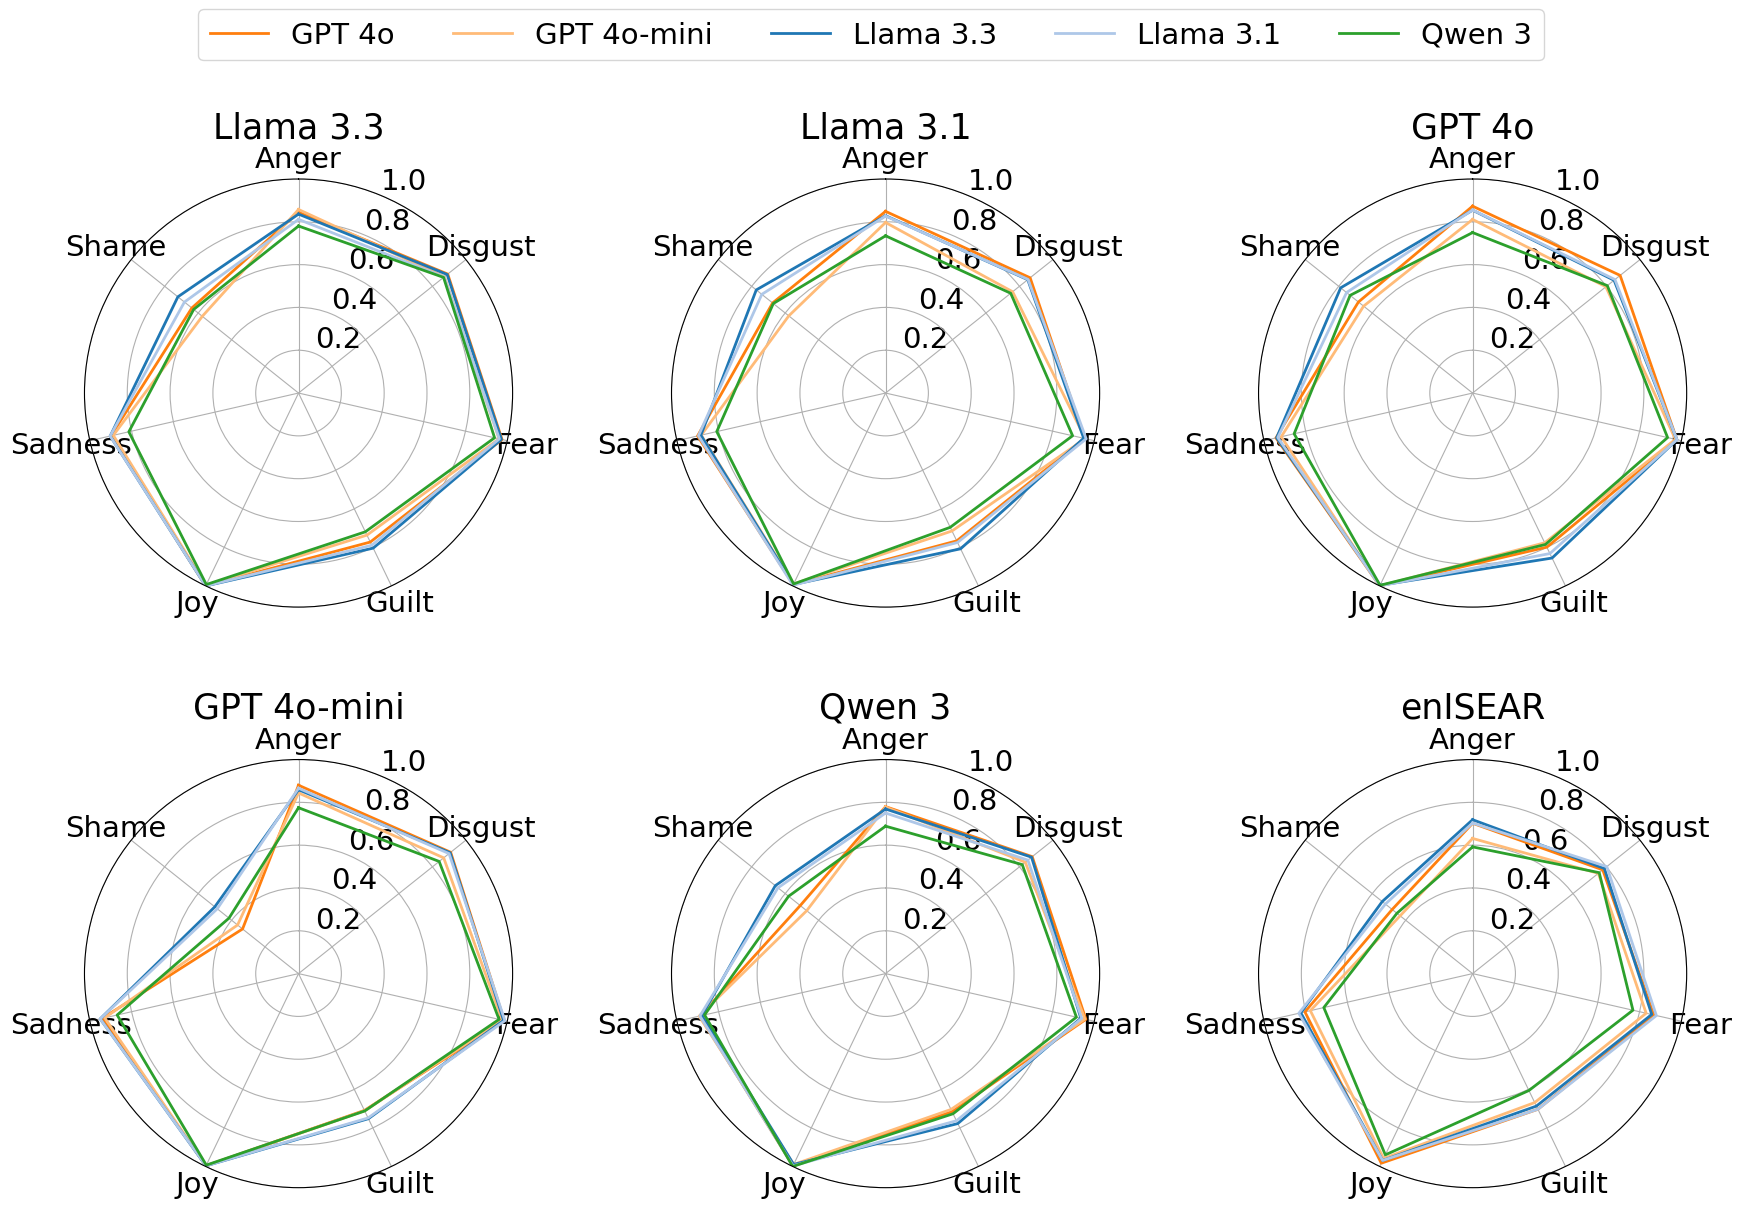

In [262]:
plot_radar_f1_from_boot(
    per_emotion_boot_results=per_emo_results,
    model_colors=model_colors,
    cols=3, label_dict=label_dict, font_size=25
)


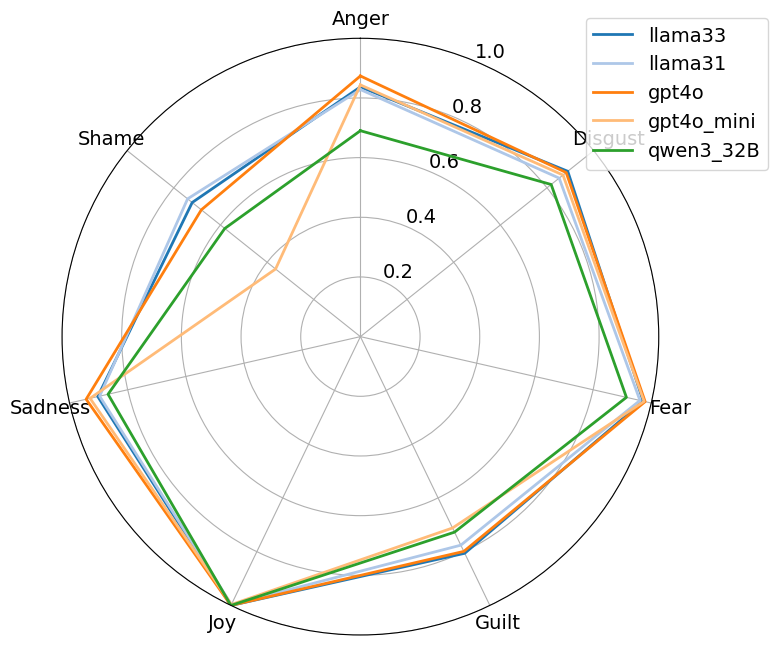

In [263]:


def plot_self_radar(models, datasets, model_colors, label_suffix="_label"):
    emotions = sorted(datasets[next(iter(datasets))]["Prior_Emotion"].unique())
    num_vars = len(emotions)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model in models:
        df = datasets[model] 
        y_true = df["Prior_Emotion"]
        y_pred = df[f"{model}{label_suffix}"]
        _, _, f1s, _ = precision_recall_fscore_support(y_true, y_pred, labels=emotions, zero_division=0)
        f1s = list(f1s) + [f1s[0]]

        color = model_colors.get(f"{model}{label_suffix}", "#333333")
        ax.plot(angles, f1s, label=model, color=color, linewidth=2)
        # ax.fill(angles, f1s, color=color, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), emotions)
    ax.set_ylim(0, 1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
    plt.tight_layout()
    plt.show()
plot_self_radar(models=datasets[:-1], datasets=synth_datasets, model_colors=model_colors)


In [264]:
label_name_map = {v: k for k, v in label_dict.items()}

records = []

for dataset_name, labelers in macro_results.items():
    for labeler, stats in labelers.items():
        labeler_clean = labeler.replace("_label", "")
        if labeler_clean == dataset_name or dataset_name == 'enisear':
            data_type = "Own Synthetic" if dataset_name == labeler_clean else "enISEAR"
            display_name = label_name_map.get(labeler, labeler_clean)
            records.append({
                "Model": display_name,
                "Dataset": data_type,
                "F1": stats["mean"],
                "Error": stats["upper"] - stats["mean"],
                "Color": model_colors.get(labeler, "#333333") if data_type == "Own Synthetic" else "#888888"
            })

own_vs_real_df = pd.DataFrame(records)
own_vs_real_df


,Model,Dataset,F1,Error,Color
0,Llama 3.3,Own Synthetic,0.874781,0.017697,#1f77b4
1,Llama 3.1,Own Synthetic,0.863858,0.020151,#aec7e8
2,GPT 4o,Own Synthetic,0.879512,0.018510,#ff7f0e
3,GPT 4o-mini,Own Synthetic,0.812472,0.021392,#ffbb78
4,Qwen 3,Own Synthetic,0.798999,0.023001,#2ca02c
5,GPT 4o,enISEAR,0.759813,0.023307,#888888
6,GPT 4o-mini,enISEAR,0.721664,0.026495,#888888
7,Llama 3.3,enISEAR,0.769023,0.024956,#888888
8,Llama 3.1,enISEAR,0.773043,0.026352,#888888
9,Qwen 3,enISEAR,0.689626,0.027487,#888888


In [265]:


def plot_macro_f1_own_vs_enisear_colored_named(df, font_size=14):


    models = sorted(df["Model"].unique())
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(["enISEAR", "Own Synthetic"]):
        subset = df[df["Dataset"] == dataset].sort_values("Model")
        offset = -width/2 if dataset == "enISEAR" else width/2
        f1s = subset["F1"].values
        errors = subset["Error"].values
        colors = subset["Color"].values

        bars = ax.bar(x + offset, f1s, width, label=dataset, yerr=errors, capsize=5, color=colors)

        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.03,
                f"{height:.2f}",
                ha='center', va='bottom',
                fontsize=font_size - 4
            )

    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=font_size)
    ax.set_ylabel("Macro F1", fontsize=font_size)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("../../images/macrof1_bar_own_vs_real.pdf", bbox_inches="tight", dpi=300)

    plt.show()


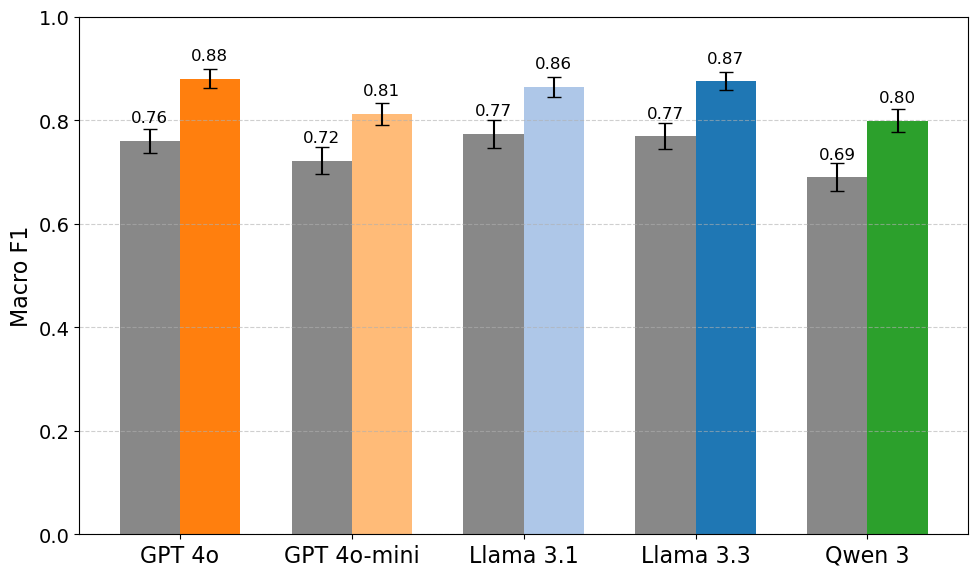

In [266]:
plot_macro_f1_own_vs_enisear_colored_named(own_vs_real_df, font_size=16)


In [274]:
label_dict
inv_label_dict = {v: k for k, v in label_dict.items()}
inv_label_dict

{'llama33_label': 'Llama 3.3',
 'llama31_label': 'Llama 3.1',
 'gpt4o_label': 'GPT 4o',
 'gpt4o_mini_label': 'GPT 4o-mini',
 'qwen3_32B_label': 'Qwen 3',
 'enisear': 'enISEAR'}

In [364]:

own_data = {}
enisear_data = {}

for dataset_name, labelers in per_emo_results.items():
    for labeler, emotion_scores in labelers.items():
        base_labeler = labeler.replace("_label", "")
        display_name = inv_label_dict.get(labeler, base_labeler)

        # Only add to "own" if labeler matches the dataset (same model)
        if dataset_name == base_labeler:
            own_data[display_name] = [
                emotion_scores[emo]["mean"] for emo in emotions
            ]

        # Add to enISEAR if the dataset is enisear
        elif dataset_name == "enisear":
            enisear_data[display_name] = [
                emotion_scores[emo]["mean"] for emo in emotions
            ]


own_df = pd.DataFrame.from_dict(own_data, orient="index", columns=emotions)
enisear_df = pd.DataFrame.from_dict(enisear_data, orient="index", columns=emotions)
ordered_models = [
    'Llama 3.3',
    'Llama 3.1',
    'GPT 4o',
    'GPT 4o-mini',
    'Qwen 3'
]
valid_models = [m for m in ordered_models if m in own_df.index and m in enisear_df.index]

own_df = own_df.loc[valid_models]
enisear_df = enisear_df.loc[valid_models]

own_df


,Anger,Fear,Joy,Sadness,Disgust,Guilt,Shame
Llama 3.3,0.835904,0.972237,1.000000,0.902241,0.888128,0.804044,0.720915
Llama 3.1,0.826921,0.961299,0.996520,0.896664,0.851371,0.774669,0.739562
GPT 4o,0.872916,0.978806,1.000000,0.942343,0.881389,0.798888,0.682243
GPT 4o-mini,0.843843,0.975062,0.996633,0.928815,0.867291,0.711420,0.364241
Qwen 3,0.688695,0.914389,1.000000,0.867181,0.816659,0.726543,0.579528


In [365]:
enisear_df

,Anger,Fear,Joy,Sadness,Disgust,Guilt,Shame
Llama 3.3,0.718934,0.858166,0.968684,0.823205,0.787352,0.686934,0.539889
Llama 3.1,0.703341,0.880459,0.968792,0.832727,0.801598,0.703338,0.521046
GPT 4o,0.702287,0.868600,0.982948,0.803553,0.777509,0.703236,0.480557
GPT 4o-mini,0.631415,0.831593,0.958392,0.777487,0.751128,0.668625,0.433008
Qwen 3,0.591901,0.768247,0.939729,0.712958,0.756359,0.606103,0.452086


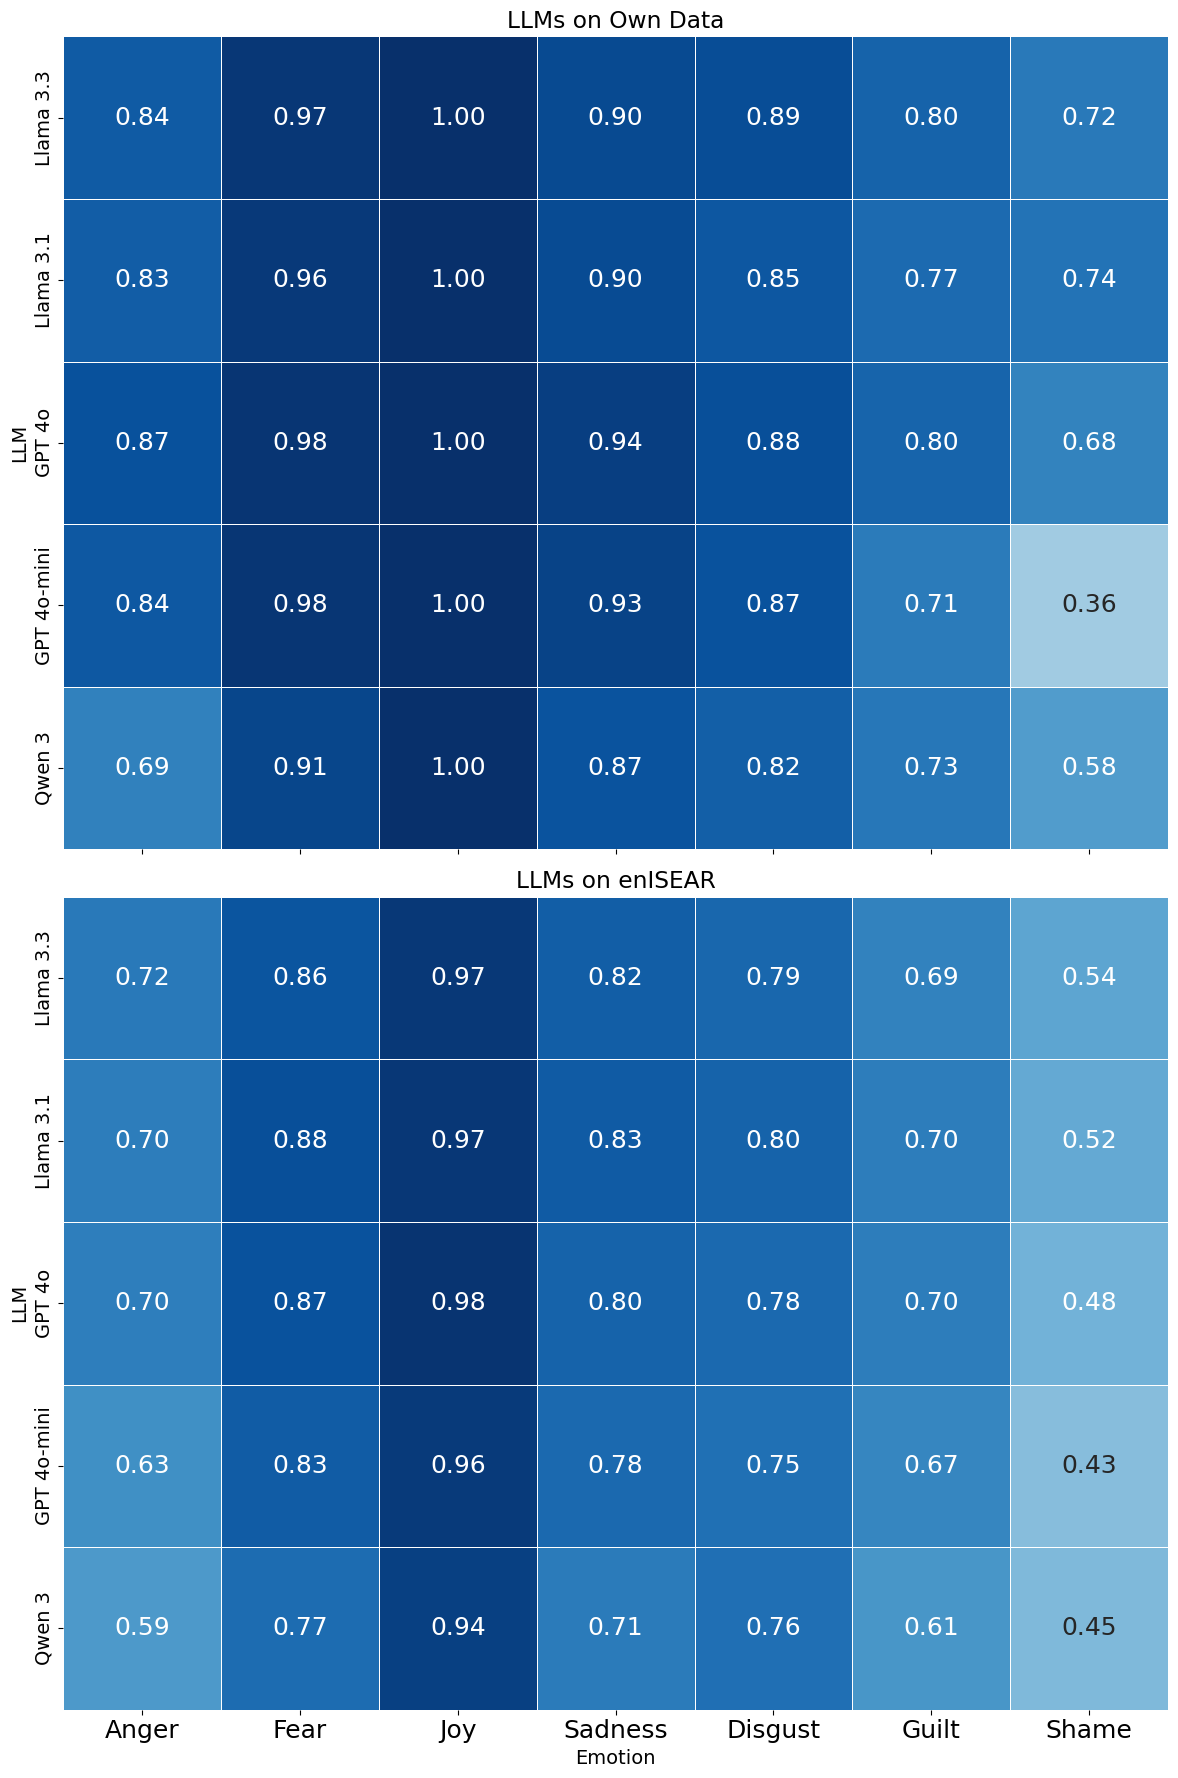

In [366]:

def plot_dual_emotion_heatmaps(own_df,enisear_df):


    fig, axes = plt.subplots(2, 1, figsize=(12, 18), sharex=True)

    sns.heatmap(own_df, ax=axes[0], annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
                linewidths=0.5,annot_kws={"size": 18}, cbar=False)

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontsize=18)


    axes[0].set_title("LLMs on Own Data")
    axes[0].set_ylabel("LLM")

    sns.heatmap(enisear_df, ax=axes[1], annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
                linewidths=0.5, annot_kws={"size": 18},cbar=False)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=18)
    axes[1].set_title("LLMs on enISEAR")
    axes[1].set_xlabel("Emotion")
    axes[1].set_ylabel("LLM")

    plt.tight_layout()
    plt.savefig("../../images/synth_per_emot_heatmap_isearvsown.pdf", bbox_inches="tight", dpi=300)

    plt.show()
plot_dual_emotion_heatmaps(own_df, enisear_df)



In [308]:
inv_label_dict

{'llama33_label': 'Llama 3.3',
 'llama31_label': 'Llama 3.1',
 'gpt4o_label': 'GPT 4o',
 'gpt4o_mini_label': 'GPT 4o-mini',
 'qwen3_32B_label': 'Qwen 3',
 'enisear': 'enISEAR'}

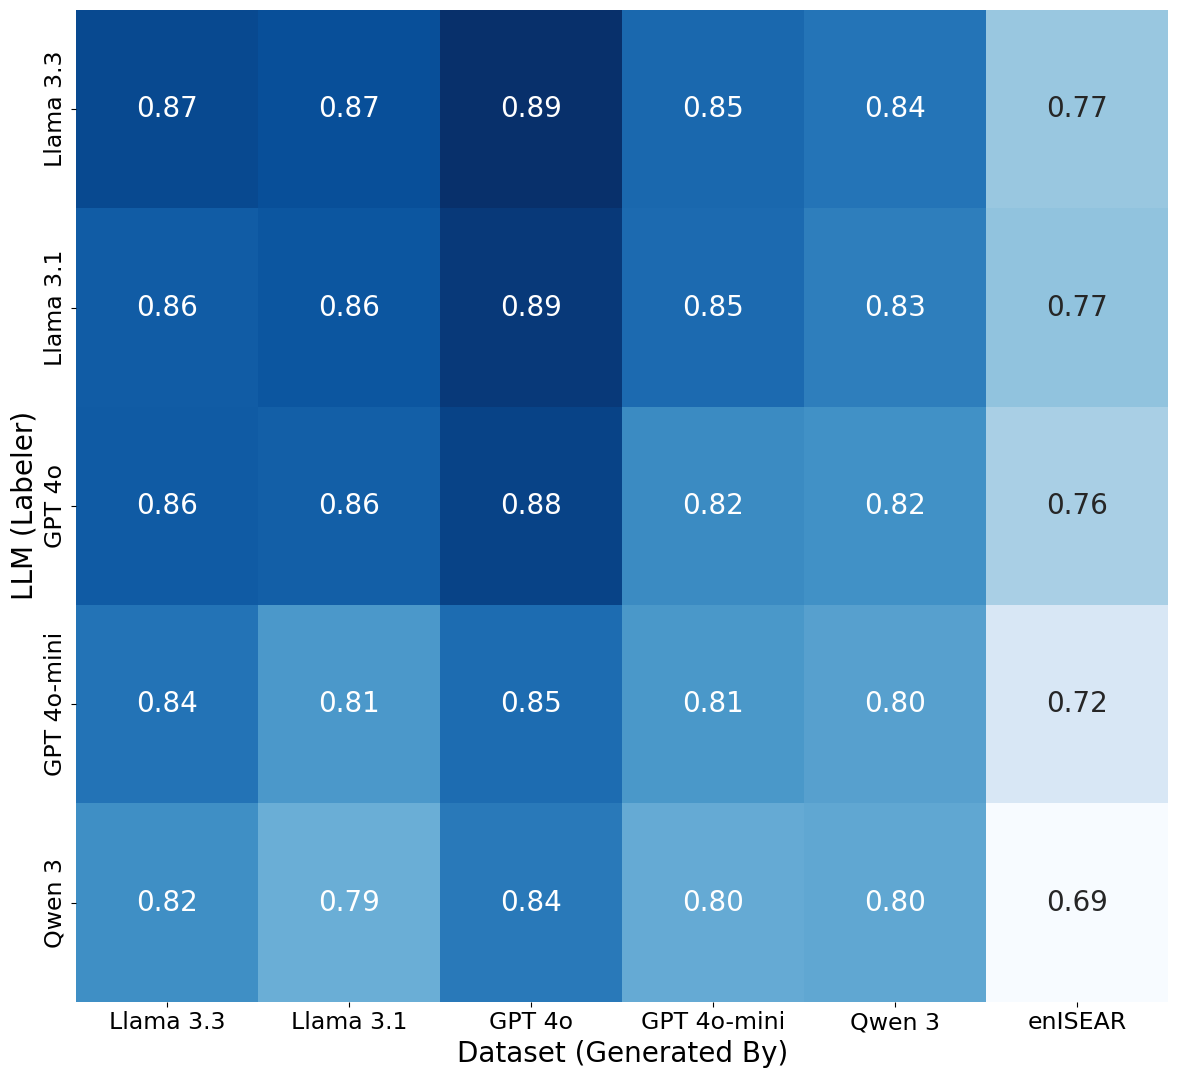

In [356]:
# Display name mapping
dataset_display_names = {
    'llama33': 'Llama 3.3',
    'llama31': 'Llama 3.1',
    'gpt4o': 'GPT 4o',
    'gpt4o_mini': 'GPT 4o-mini',
    'qwen3_32B': 'Qwen 3',
    'enisear': 'enISEAR'
}

f1_data_extended = {}
for dataset_name, labelers in macro_results.items():
    for labeler, stats in labelers.items():
        f1_mean = stats["mean"]
        if labeler not in f1_data_extended:
            f1_data_extended[labeler] = {}
        f1_data_extended[labeler][dataset_name] = f1_mean

f1_df_ext = pd.DataFrame(f1_data_extended).T

f1_df_ext.index = [inv_label_dict.get(idx, idx) for idx in f1_df_ext.index]
f1_df_ext.columns = [dataset_display_names.get(col, col) for col in f1_df_ext.columns]

ordered_models = [
    'Llama 3.3',
    'Llama 3.1',
    'GPT 4o',
    'GPT 4o-mini',
    'Qwen 3'
]

ordered_columns = ordered_models + ['enISEAR']

f1_df_ext = f1_df_ext.loc[ordered_models]
f1_df_ext = f1_df_ext[ordered_columns]

plt.figure(figsize=(12, 11))
sns.heatmap(
    f1_df_ext,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 20}
)
plt.xlabel("Dataset (Generated By)", fontsize=20)
plt.ylabel("LLM (Labeler)", fontsize=20)
plt.xticks(rotation=0, fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.savefig("../../images/heatmap_llms_on_all_data_synth.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [329]:
def build_emotion_grid_data_from_boot(per_emo_results, inv_label_dict, dataset_display_names):
    raw_labelers = list(next(iter(per_emo_results.values())).keys())
    raw_generators = list(per_emo_results.keys())

    labelers = [inv_label_dict.get(lab, lab.replace("_label", "")) for lab in raw_labelers]
    generators = [dataset_display_names.get(gen, gen) for gen in raw_generators]

    emotion_data = {}
    for emotion in emotions:
        df = pd.DataFrame(index=labelers, columns=generators, dtype=float)
        for raw_gen in raw_generators:
            gen_disp = dataset_display_names.get(raw_gen, raw_gen)
            for raw_lab in per_emo_results[raw_gen]:
                lab_disp = inv_label_dict.get(raw_lab, raw_lab.replace("_label", ""))
                if emotion in per_emo_results[raw_gen][raw_lab]:
                    df.loc[lab_disp, gen_disp] = per_emo_results[raw_gen][raw_lab][emotion]["mean"]
        emotion_data[emotion] = df
    return emotion_data


In [410]:
def plot_dual_confusion(llm_name, display_name, datasets, font_size=10):
    real_df = datasets['enisear']
    y_true_real = real_df["Prior_Emotion"]
    y_pred_real = real_df[f"{llm_name}_label"]
    cm_real = confusion_matrix(y_true=y_true_real, y_pred=y_pred_real, normalize='true', labels=emotions)

    syn_df = datasets[llm_name]
    y_true_syn = syn_df["Prior_Emotion"]
    y_pred_syn = syn_df[f"{llm_name}_label"]
    cm_syn = confusion_matrix(y_true=y_true_syn, y_pred=y_pred_syn, normalize='true', labels=emotions)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(17, 10), sharey=True)

    sns.heatmap(cm_real, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=emotions, yticklabels=emotions,
                ax=axes[0], annot_kws={"fontsize": font_size-4}, cbar=False)
    axes[0].set_title(f"{display_name} on Real Data (enISEAR)", fontsize=font_size)
    axes[0].set_xticklabels(emotions, rotation=0, fontsize=font_size-4)
    axes[0].set_yticklabels(emotions, rotation=0, fontsize=font_size-4)
    axes[0].set_xlabel("Predicted", fontsize=font_size-2)
    axes[0].set_ylabel("True", fontsize=font_size-2)

    sns.heatmap(cm_syn, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=emotions, yticklabels=emotions,
                ax=axes[1], annot_kws={"fontsize": font_size-4}, cbar=False)
    axes[1].set_title(f"{display_name} on Own Synthetic Data", fontsize=font_size)
    axes[1].set_xticklabels(emotions, rotation=0, fontsize=font_size-4)
    axes[1].set_yticklabels(emotions, rotation=0, fontsize=font_size-4)
    axes[1].set_xlabel("Predicted", fontsize=font_size-2)
    axes[1].set_ylabel("")  # Already shown on left

    plt.tight_layout()
    plt.savefig(f"../../images/confusion_matrix_synth_vs_ensiear-{llm_name}.pdf", bbox_inches="tight", dpi=300)

    plt.show()


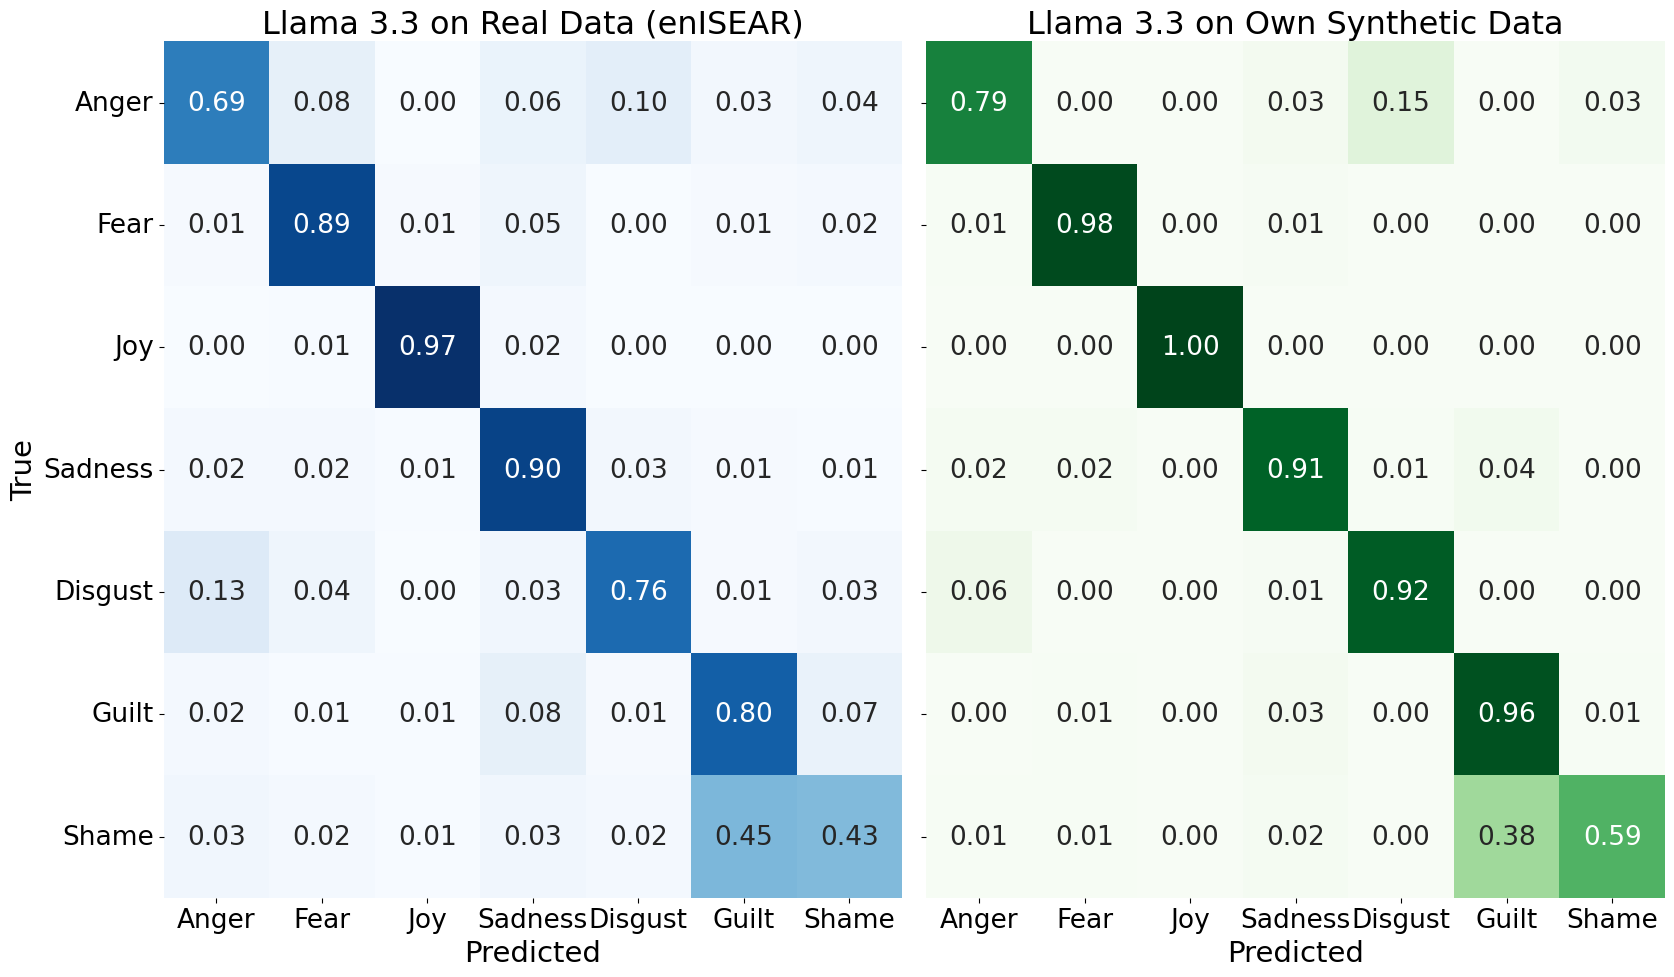

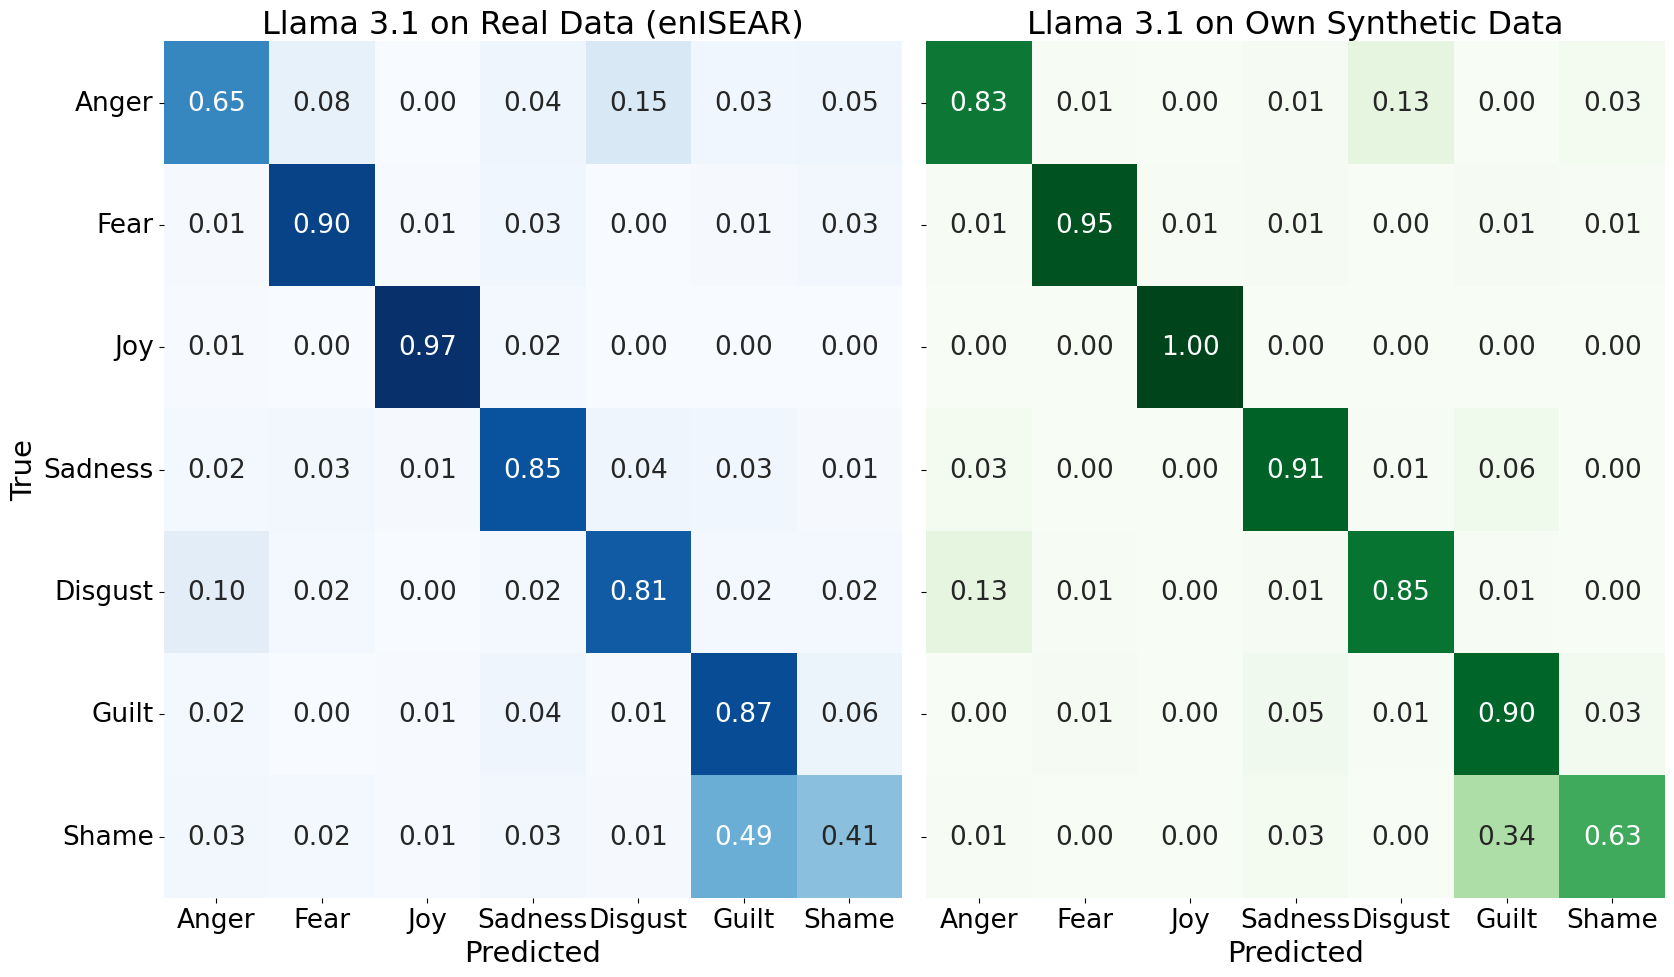

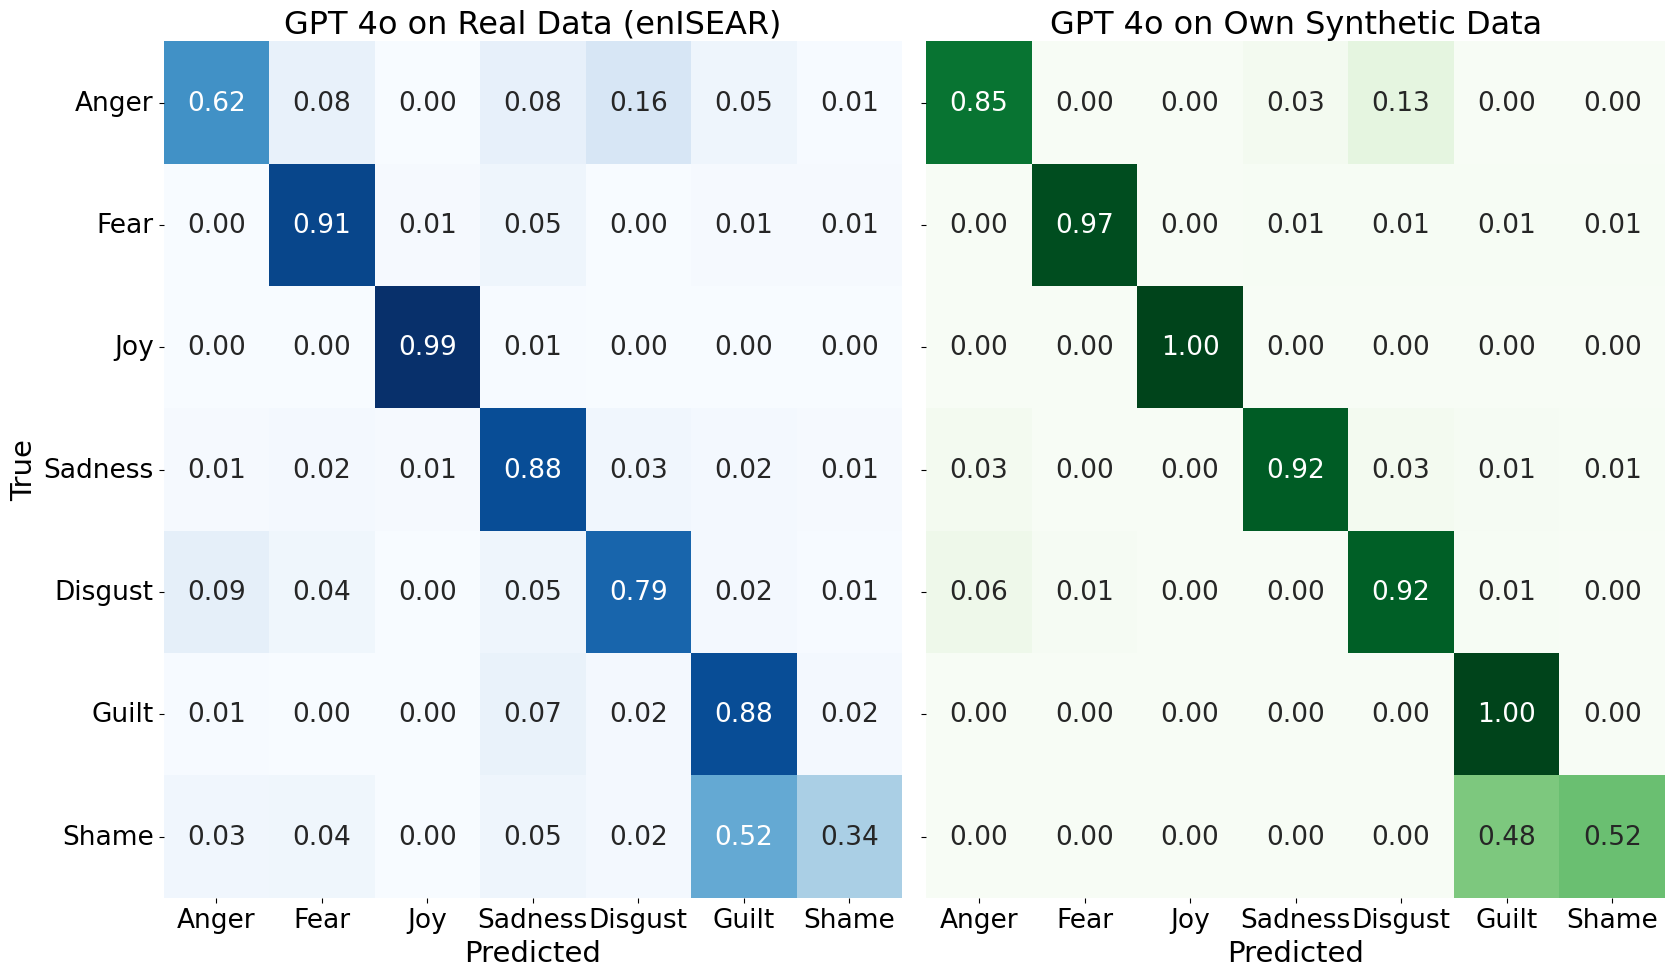

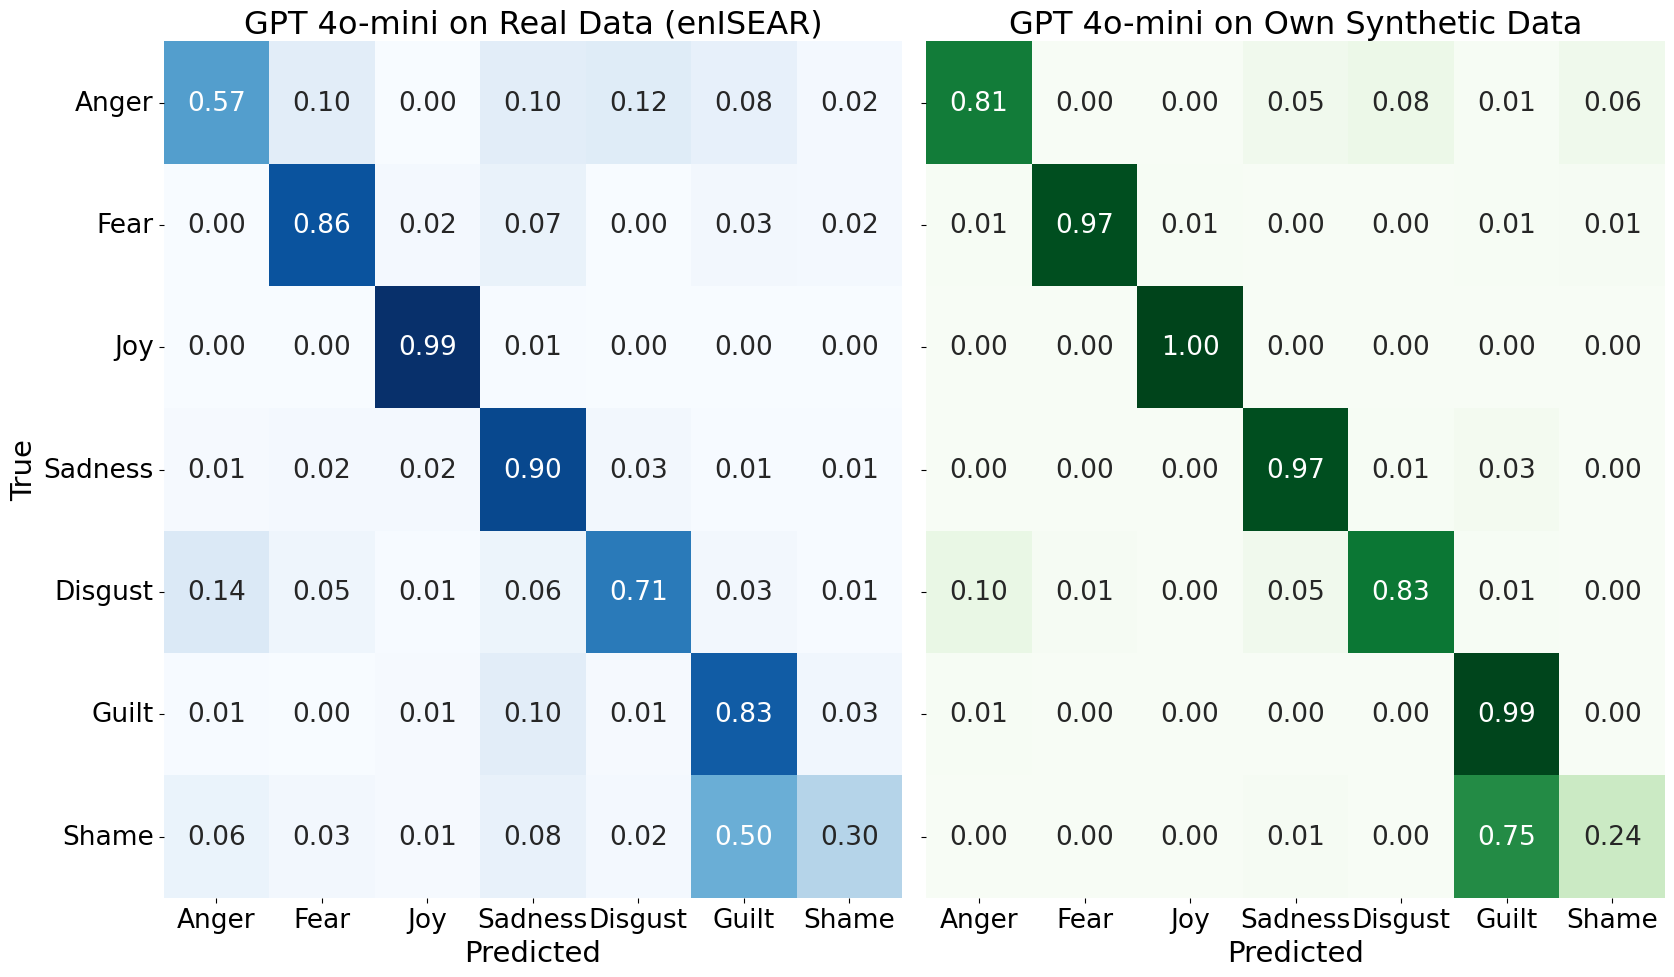

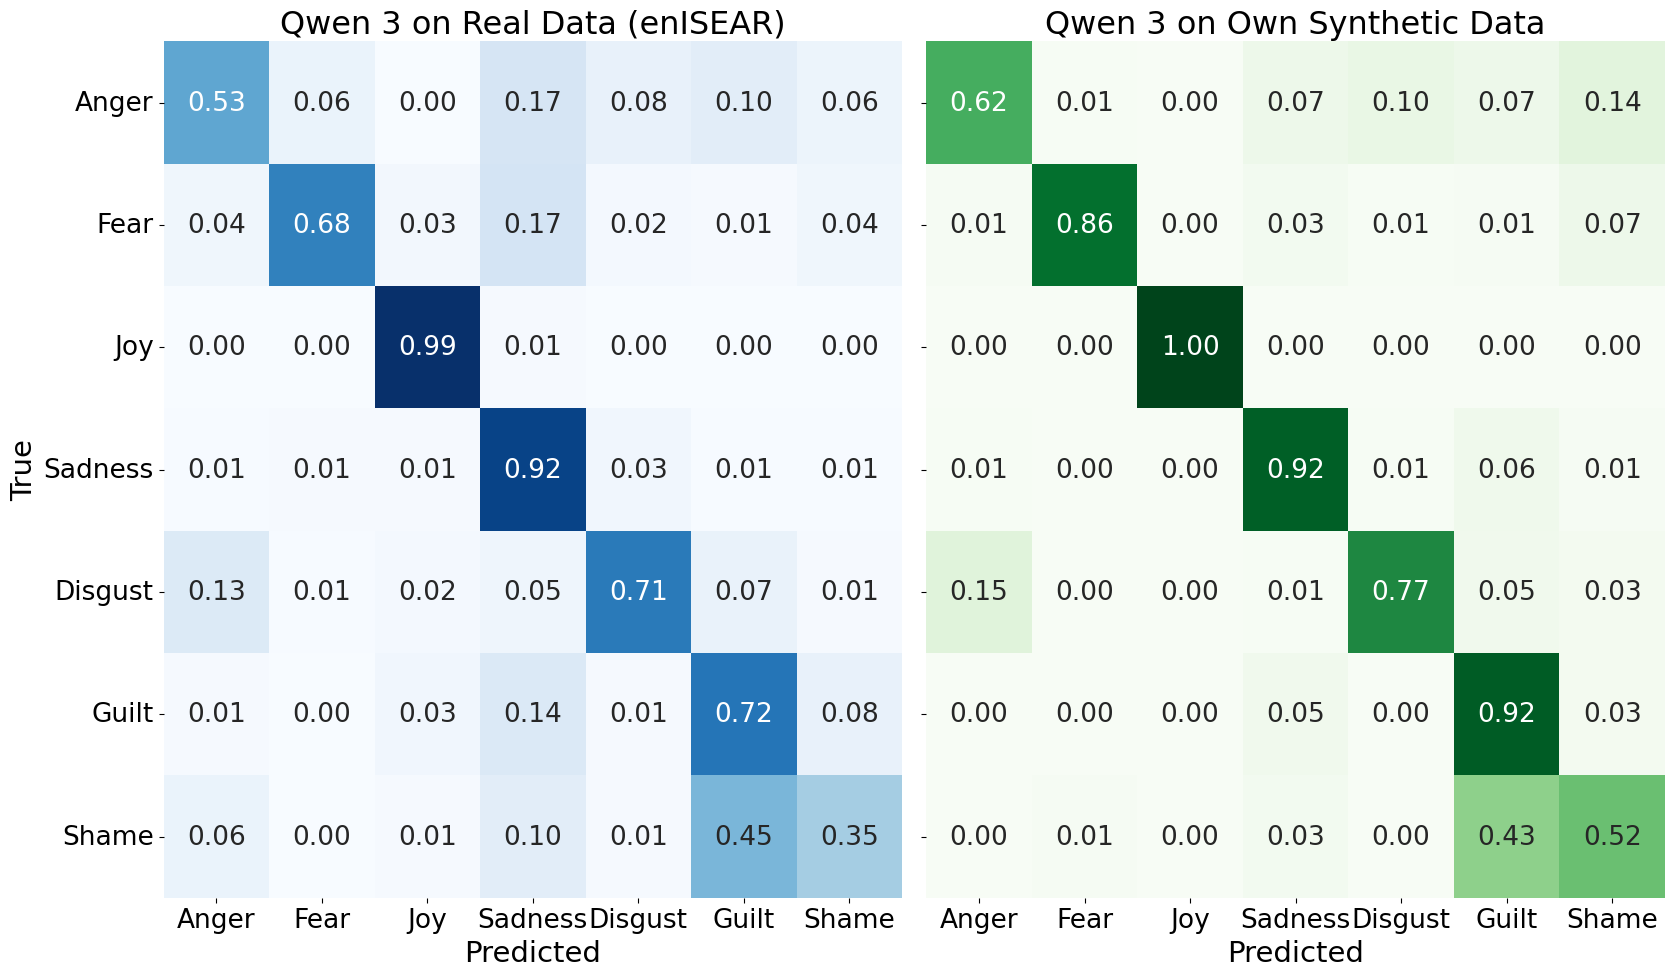

In [411]:
for data, name in list(dataset_display_names.items())[:-1]:
    plot_dual_confusion(data, name, synth_datasets, 23)
